Plotting amortized roi over time using Sheet 1

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
# Go into above directory and download function
sys.path.append('../../') 
import sheet_to_df


In [3]:
# Extract sheet id - last number of google sheet
sheet_id = 0

df = sheet_to_df.sheet_to_df(sheet_id, 'Sheet1')

In [4]:
# Function that will take in a value for n and return an array of amortized values
# that correspond to the 1-8 time complexty classes
def amort_vals(n):
    one = 1 #constant
    two = np.log(n) #logn
    three = n #linear
    four = n*np.log(n) #quasilinear
    five = n**2 #quadratic
    six = n**3 #cubic
    seven = n**5 #polynomial >3
    eight = np.math.factorial(n)
    return [one, two, three, four, five, six, seven, eight]

amortized_vals = amort_vals(1000)

In [5]:
# Select the required columns
selected_columns = ['Family Name', 'Year', 'Time Complexity Improvement?', 'Transition Class', 'Time Complexity Class']
df = df.loc[:, selected_columns].copy()

# Filter the rows where 'Time Complexity Improvement?' is 1
df = df[df['Time Complexity Improvement?'] == 1].copy()

# Sort the DataFrame by 'Year'
df = df.sort_values(by='Year')

# Take out all values before the year 1940
df = df[df['Year'] > 1939]

In [6]:
# Define the function to calculate transition difference
def calculate_transition_difference(entry):
    if entry == '0' or entry == '-' or entry == '1':
        return 0
    num1, num2 = map(int, entry.split("->"))
    return amortized_vals[num2-1] / amortized_vals[num1 -1]
df['Transition Difference'] = df['Transition Class'].apply(calculate_transition_difference)

For each of the algorithm DF's, we want to plot the Amortized time (y-axis) found by taking the size of the improvement, plugging in a value for n (1mil), and dividing by the number of years since the last improvement

In [1]:
family_name_dfs = {family_name: df[df['Family Name'] == family_name].copy() 
                   for family_name in df['Family Name'].unique()}

for family_name, family_df in family_name_dfs.items():
    # Compute years since the previous improvement and improvement
    years_since_improvement = []
    prev_year = None
    for index, row in family_df.iterrows():
        if prev_year is None:
            years_since_improvement.append(0) 
        else:
            years_since_improvement.append(row['Year'] - prev_year)
        # Update the previous year to the current row's year for the next iteration
        prev_year = row['Year']

    family_df['Years Since Last Improvement'] = years_since_improvement

    # Before calculating the improvement rate, replace 0 with np.nan to prevent division by zero
    family_df['Improvement Rate (%)'] = family_df['Transition Difference'] / family_df['Years Since Last Improvement'].apply(lambda x: max(1, x))

    # Make a column for absolute year
    abs_year = family_df['Year'].min()
    family_df['Absolute Year'] = family_df['Year'] - abs_year + 1940

    # Bin the columns in years of 5
    bins = np.linspace(1940, 2025, 18)
    family_df['binned'] = pd.cut(family_df['Year'], bins=bins)

    # Replace the original dataframe in the dictionary
    family_name_dfs[family_name] = family_df

# You can also fill infinite values with NaN after the calculation if needed
for family_name, family_df in family_name_dfs.items():
    family_df['Improvement Rate (%)'].replace(np.inf, np.nan, inplace=True)
    family_df['Improvement Rate (%)'].replace(-np.inf, np.nan, inplace=True)

NameError: name 'df' is not defined

In [55]:
def abs_year_plot(family_df, family_name):
    if family_df['Absolute Year'].max() > 0:
        years = list(range(0, int(family_df['Absolute Year'].max())))
        improvements = []

        for year in years:
            if year in family_df['Absolute Year'].values:
                improvements.append(family_df[family_df['Absolute Year'] == year]['Improvement Rate (%)'].values[0])
            else:
                improvements.append(0)

        plt.figure(figsize=(3, 1))
        plt.plot(years, improvements, linestyle='-', color='blue')
        plt.title(f"Improvement Rate (%) over Years for {family_name}")
        plt.xlabel("Year")
        plt.ylabel("Improvement Rate (%)")
        plt.grid(True)
        plt.show()
    # Plot for each family
# for family_name, family_df in family_name_dfs.items():
#     abs_year_plot(family_df, family_name)

In [11]:
def time_series_plot(family_df, family_name):
    # Create a series of years from 1940 to 2023
    years = list(range(1940, 2023))
    improvements = []
    
    # For each year, check if there's an improvement, if not append 0
    for year in years:
        if year in family_df['Year'].values:
            improvements.append(family_df[family_df['Year'] == year]['Improvement Rate (%)'].values[0])
        else:
            improvements.append(0)
    
    # Plot
    plt.figure(figsize=(3, 1))
    plt.plot(years, improvements, linestyle='-', color='blue')
    plt.title(f"Improvement Rate (%) over Years for {family_name}")
    plt.xlabel("Year")
    plt.ylabel("Improvement Rate (%)")
    plt.grid(True)
    plt.show()

# Plot for each family
# for family_name, family_df in family_name_dfs.items():
#     time_series_plot(family_df, family_name)

In [12]:
def cum_time_series_plot(family_df, family_name):
    # Create a series of years from 1940 to 2023
    years = list(range(1940, 2024))
    improvements = []
    cumulative_improvements = 0  # To store the cumulative sum
    
    # For each year, check if there's an improvement, if not append the last cumulative sum
    for year in years:
        if year in family_df['Year'].values:
            cumulative_improvements += family_df[family_df['Year'] == year]['Improvement Rate (%)'].values[0]
            improvements.append(cumulative_improvements)
        else:
            improvements.append(cumulative_improvements)
    
    # Plot
    plt.figure(figsize=(3, 1))
    plt.plot(years, improvements, linestyle='-')
    plt.title(f"Cumulative Improvement Rate (%) over Years for {family_name}")
    plt.xlabel("Year")
    plt.ylabel("Cumulative Improvement Rate (%)")
    plt.grid(True)
    plt.show()

# Plot for each family
# for family_name, family_df in family_name_dfs.items():
#     cum_time_series_plot(family_df, family_name)


In [56]:
# Create a DataFrame that captures all years and families
all_years_df = pd.concat(family_name_dfs.values(), ignore_index=True)

# Adding a small constant (e.g., 1) to ensure all values are > 0
all_years_df['Improvement Rate (%)'] = all_years_df['Improvement Rate (%)']

# Sort df by year
all_years_df = all_years_df.sort_values(by='Year')


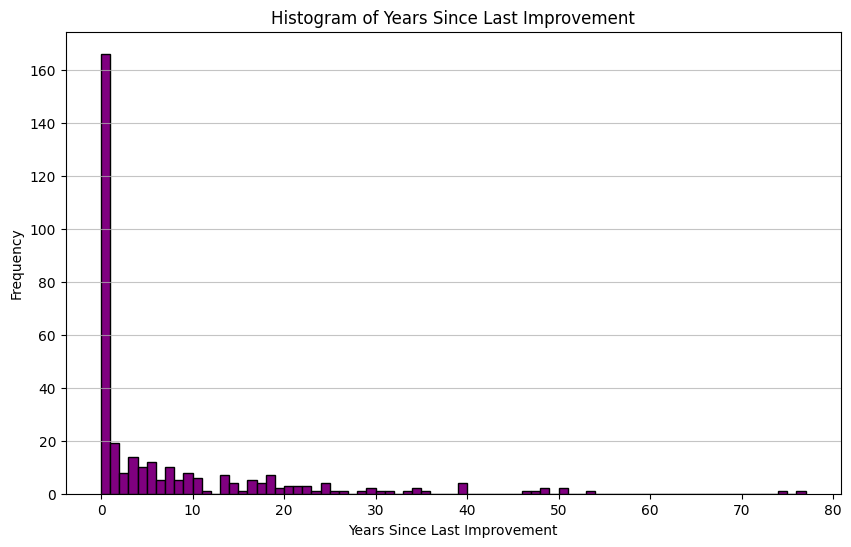

In [45]:
# Plot a histogram of the 'Years Since Last Improvement'
plt.figure(figsize=(10, 6))
plt.hist(all_years_df['Years Since Last Improvement'], bins=range(int(all_years_df['Years Since Last Improvement'].min()), int(all_years_df['Years Since Last Improvement'].max()) + 1), color='purple', edgecolor='black')
plt.title('Histogram of Years Since Last Improvement')
plt.xlabel('Years Since Last Improvement')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

factor out first algorithms

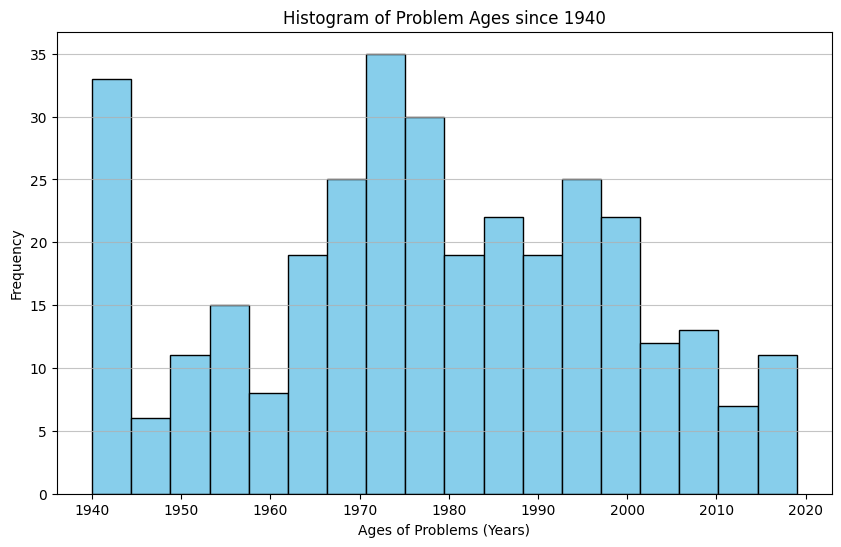

In [61]:
# Plot a histogram of the problem ages
plt.figure(figsize=(10, 6))
plt.hist(all_years_df['Year'], bins=18 , color='skyblue', edgecolor='black')
plt.title('Histogram of Problem Ages since 1940')
plt.xlabel('Ages of Problems (Years)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

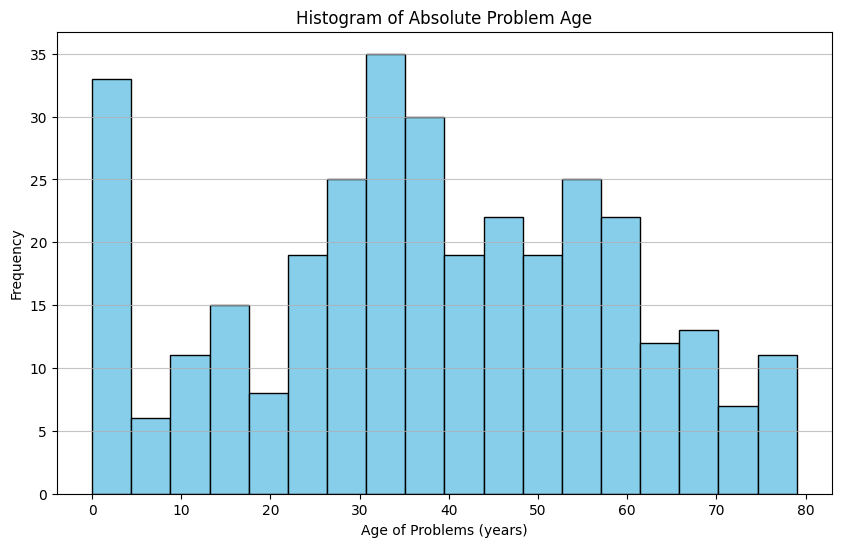

In [58]:
all_years_df['Problem Age'] =  all_years_df['Year'] - 1940

# Now plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(all_years_df['Problem Age'], bins=18, color='skyblue', edgecolor='black')  # Adjust bins if needed
plt.title('Histogram of Absolute Problem Age')
plt.xlabel('Age of Problems (years)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [16]:
def custom_median(series):
    median_val = series.median()
    if median_val == 0:
        greater_than_one = series[series > 1]
        if not greater_than_one.empty:
            return greater_than_one.min()  # Return the minimum value greater than 0
        else:
            return median_val  # If there are no values greater than 0, return the median itself
    else:
        return median_val  # If the median is not 0, just return the median

In [47]:
def prepare_data(df):
    # Create a new dataframe with index as all the years from 1940 to 2023
    years_df = pd.DataFrame(index=range(1940, 2023))
    
    
    # Calculate average improvement for each year
    avg_mean_improvement = df.groupby('Year')['Improvement Rate (%)'].mean()
    # avg_median_improvement = df.groupby('Year')['Improvement Rate (%)'].median()
    avg_median1_improvement = df.groupby('Year')['Improvement Rate (%)'].apply(custom_median)
    abs_avg_mean_improvement = df.groupby('Absolute Year')['Improvement Rate (%)'].mean()
    # abs_avg_median_improvement = df.groupby('Absolute Year')['Improvement Rate (%)'].median()
    abs_avg_median1_improvement = df.groupby('Absolute Year')['Improvement Rate (%)'].apply(custom_median)
    
    # Add this to the new dataframe
    years_df['Average Mean Improvement'] = avg_mean_improvement
    years_df['Average Median Improvement'] = avg_median1_improvement
    years_df['Abs Average Mean Improvement'] = abs_avg_mean_improvement
    years_df['Abs Average Median Improvement'] = abs_avg_median1_improvement

    
    # Forward fill NaN values with 0, as there might be years without any improvement
    years_df.fillna(0, inplace=True)
    years_df['Average Mean Improvement'] = years_df['Average Mean Improvement'] + 1
    years_df['Average Median Improvement'] = years_df['Average Median Improvement'] + 1
    years_df['Abs Average Mean Improvement'] = years_df['Abs Average Mean Improvement'] + 1
    years_df['Abs Average Median Improvement'] = years_df['Abs Average Median Improvement'] + 1
    
    # Calculate the cumulative sum for the improvements
    years_df['Cumulative Mean Improvement'] = years_df['Average Mean Improvement'].cumsum()
    years_df['Cumulative Median Improvement'] = years_df['Average Median Improvement'].cumsum()
    years_df['Abs Cumulative Mean Improvement'] = years_df['Abs Average Mean Improvement'].cumsum()
    years_df['Abs Cumulative Median Improvement'] = years_df['Abs Average Median Improvement'].cumsum()
    
    return years_df

def plot_mean_data(df):
    plt.figure(figsize=(12, 6))
    
    # Plot average and cumulative improvements
    plt.plot(df.index-1940, df['Average Mean Improvement'], label='Average Mean Improvement', marker='o')
    plt.plot(df.index-1940, df['Cumulative Mean Improvement'], label='Cumulative Mean Improvement', linestyle='--')
    plt.yscale("log")  # Use logarithmic scale for the y-axis
    plt.title("Mean Improvement Over the Years 1940-2023")
    plt.xlabel("Year")
    plt.ylabel("Improvement Rate (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_median_data(df):
    plt.figure(figsize=(12, 6))
    
    # Plot average and cumulative improvements
    plt.plot(df.index-1940, df['Average Median Improvement'], label='Average Median Improvement', marker='o')
    plt.plot(df.index-1940, df['Cumulative Median Improvement'], label='Cumulative Median Improvement', linestyle='--')
    plt.yscale("log")  # Use logarithmic scale for the y-axis
    plt.title("Median Improvement Over the Years 1940-2023")
    plt.xlabel("Year")
    plt.ylabel("Improvement Rate (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_abs_mean_data(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index-1940, df['Abs Average Mean Improvement'], label='Abs Average Mean Improvement', marker='o')
    plt.plot(df.index-1940, df['Abs Cumulative Mean Improvement'], label='Abs Cumulative Mean Improvement', linestyle='--')
    plt.yscale("log")  # Use logarithmic scale for the y-axis
    plt.title("Absolute Mean Improvement Over the Years 1940-2023")
    plt.xlabel("Year")
    plt.ylabel("Improvement Rate (%)")
    plt.legend()
    plt.grid(True)

def plot_abs_median_data(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index-1940, df['Abs Average Median Improvement'], label='Abs Average Median Improvement', marker='s')
    plt.plot(df.index-1940, df['Abs Cumulative Median Improvement'], label='Abs Cumulative Median Improvement', linestyle='--')
    plt.yscale("log")  # Use logarithmic scale for the y-axis
    plt.title("Absolute Median Improvements Over the Years 1940-2023")
    plt.xlabel("Year")
    plt.ylabel("Improvement Rate (%)")
    plt.legend()
    plt.grid(True)
    
    plt.show()

In [48]:
prepared_data = prepare_data(all_years_df)
prepared_data

,Average Mean Improvement,Average Median Improvement,Abs Average Mean Improvement,Abs Average Median Improvement,Cumulative Mean Improvement,Cumulative Median Improvement,Abs Cumulative Mean Improvement,Abs Cumulative Median Improvement
1940,4.418116e+03,1001.000000,1931.478831,7.907755,4.418116e+03,1001.000000,1.931479e+03,7.907755
1941,1.000000e+00,1.000000,383.739568,145.764827,4.419116e+03,1002.000000,2.315218e+03,153.672583
1942,1.000000e+00,1.000000,251.863469,2.726939,4.420116e+03,1003.000000,2.567082e+03,156.399521
1943,1.000000e+00,1.000000,112.878639,3.302585,4.421116e+03,1004.000000,2.679961e+03,159.702106
1944,1.000000e+00,1.000000,13.063736,37.191207,4.422116e+03,1005.000000,2.693024e+03,196.893313
...,...,...,...,...,...,...,...,...
2018,7.246379e+06,5.257789,5.257789,5.257789,1.324602e+08,140586.966491,1.722687e+08,153417.797714
2019,2.507967e+00,2.507967,2.507967,2.507967,1.324602e+08,140589.474458,1.722687e+08,153420.305681
2020,1.000000e+00,1.000000,1.000000,1.000000,1.324602e+08,140590.474458,1.722687e+08,153421.305681
2021,1.000000e+00,1.000000,1.000000,1.000000,1.324602e+08,140591.474458,1.722687e+08,153422.305681


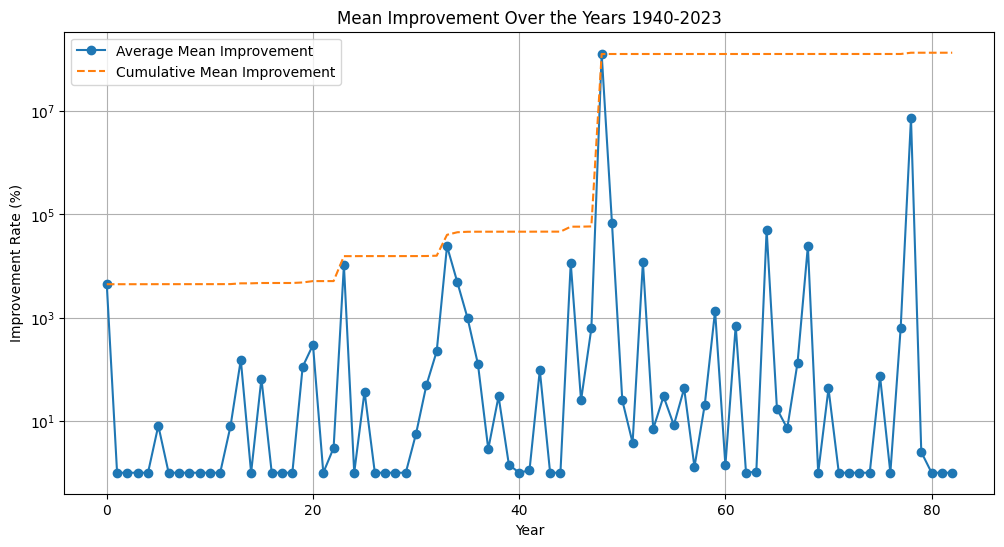

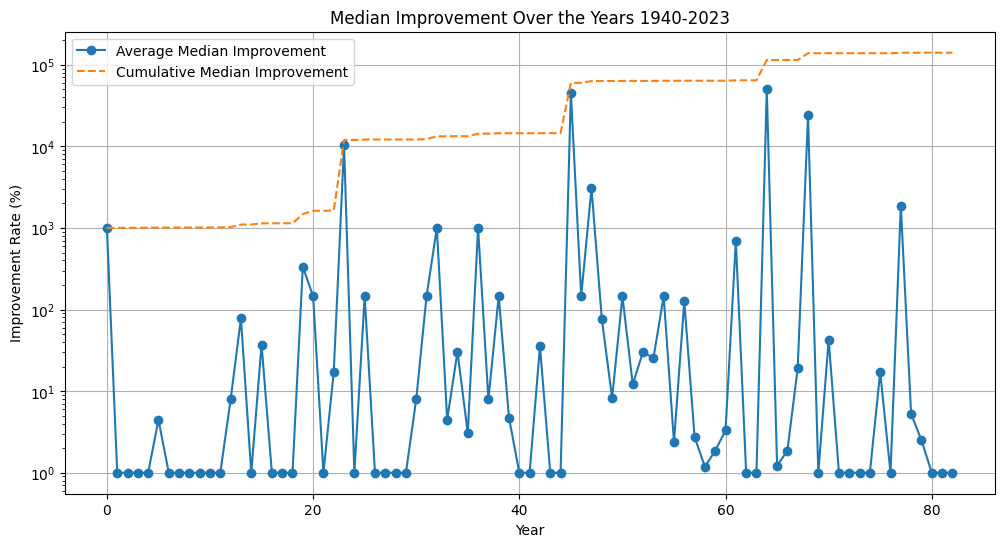

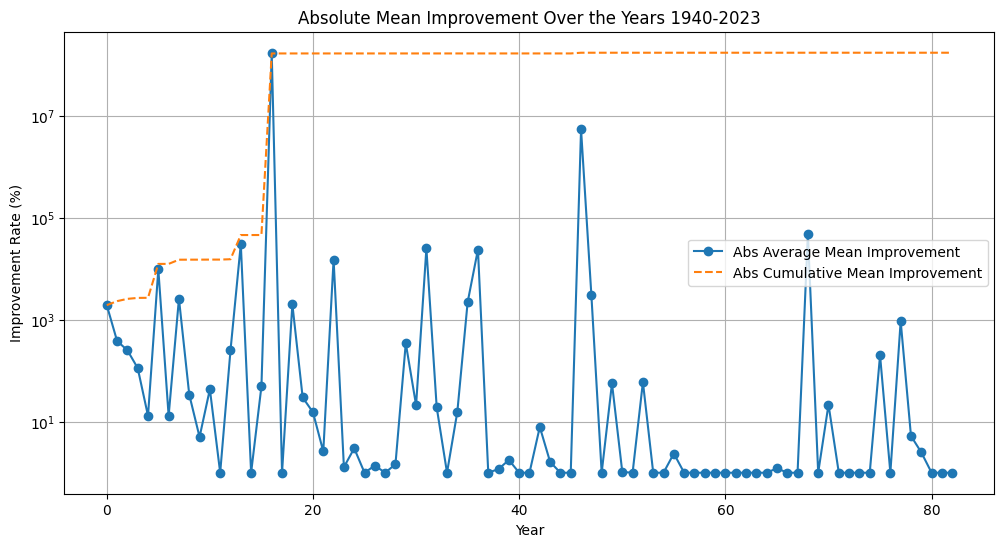

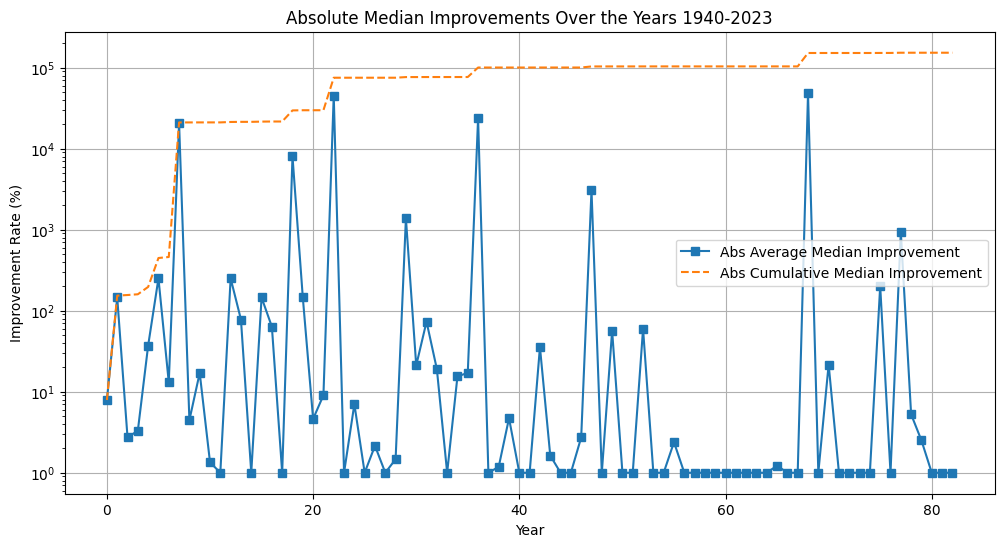

In [49]:

plot_mean_data(prepared_data)
plot_median_data(prepared_data)
plot_abs_mean_data(prepared_data)
plot_abs_median_data(prepared_data)


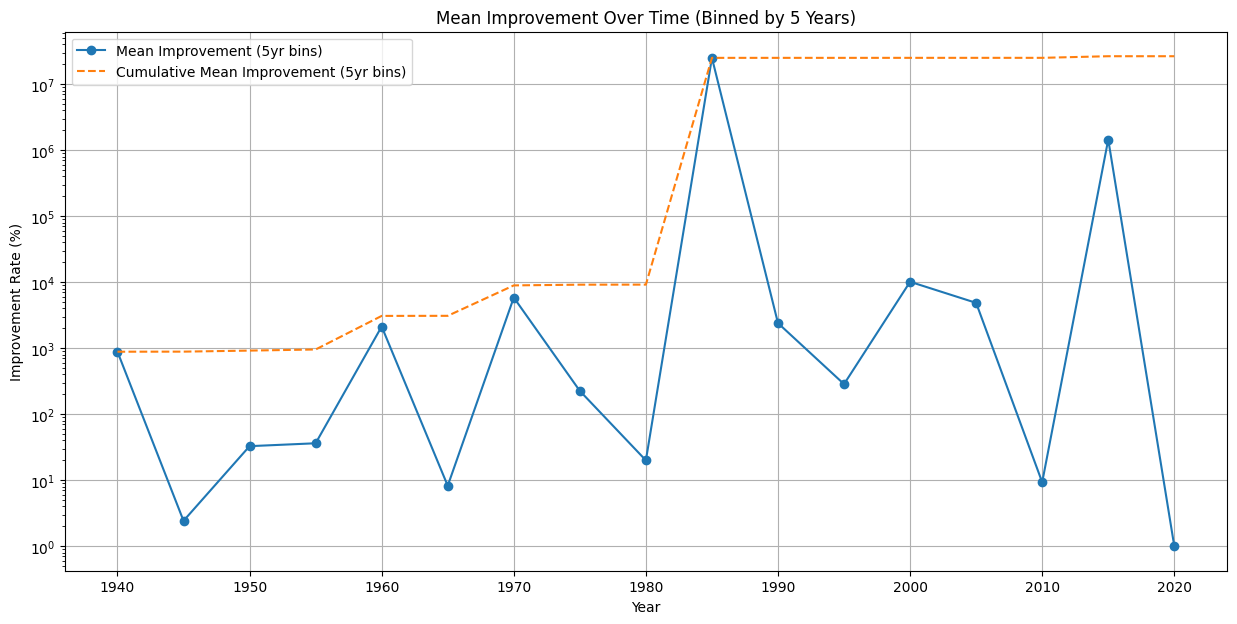

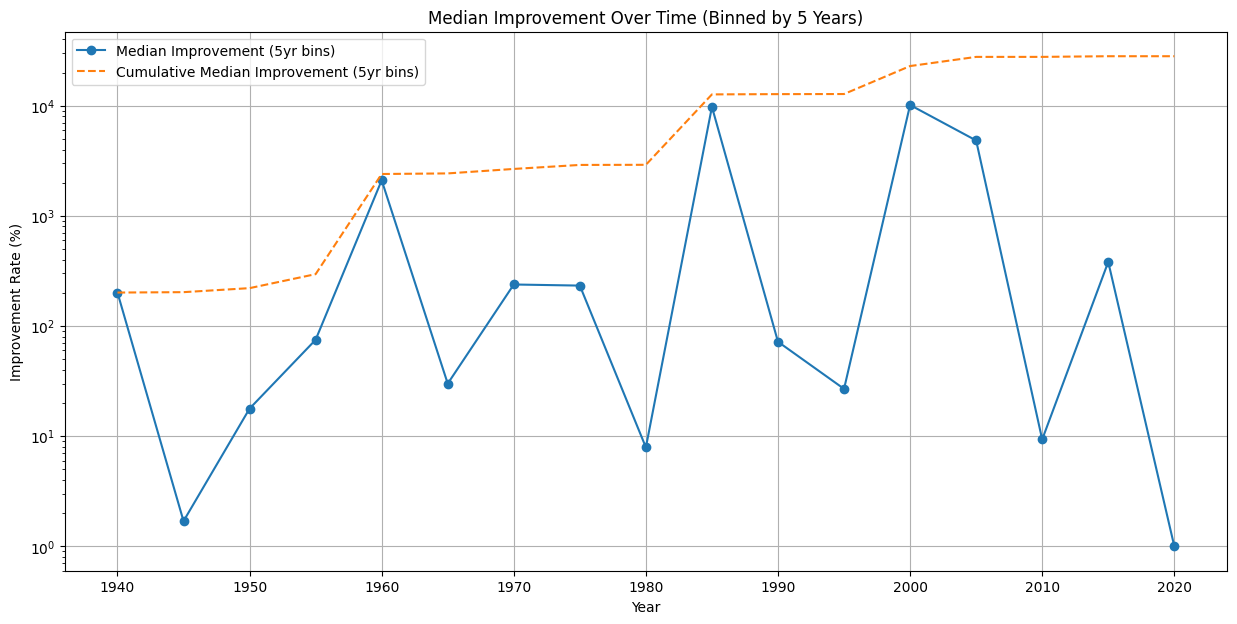

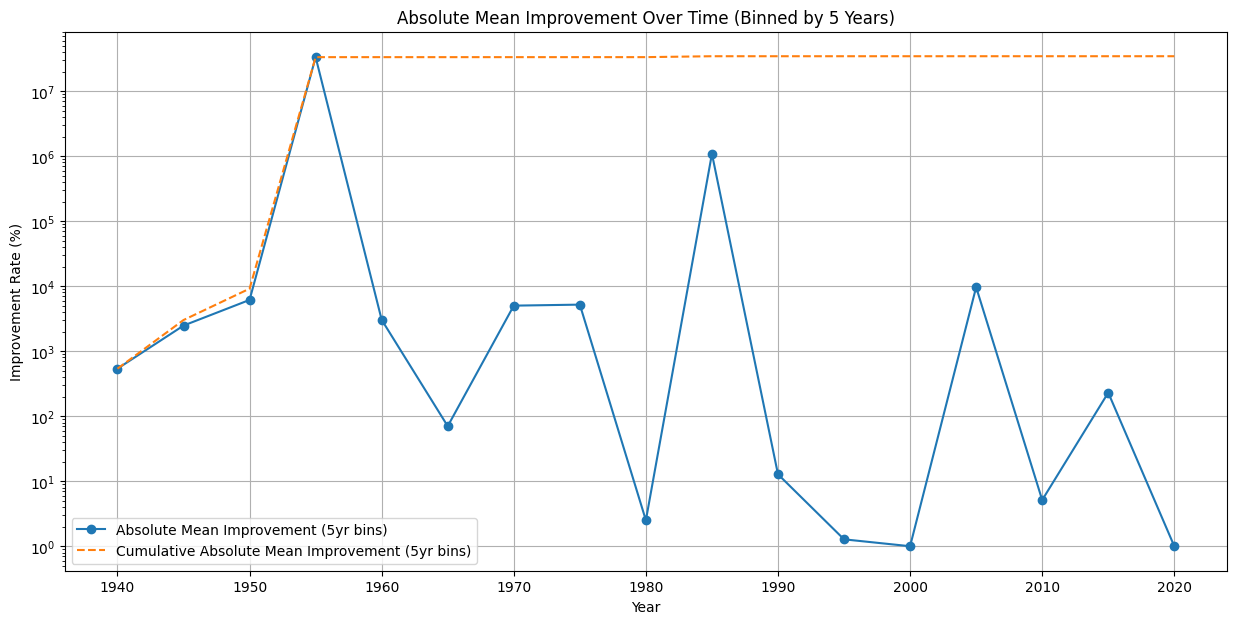

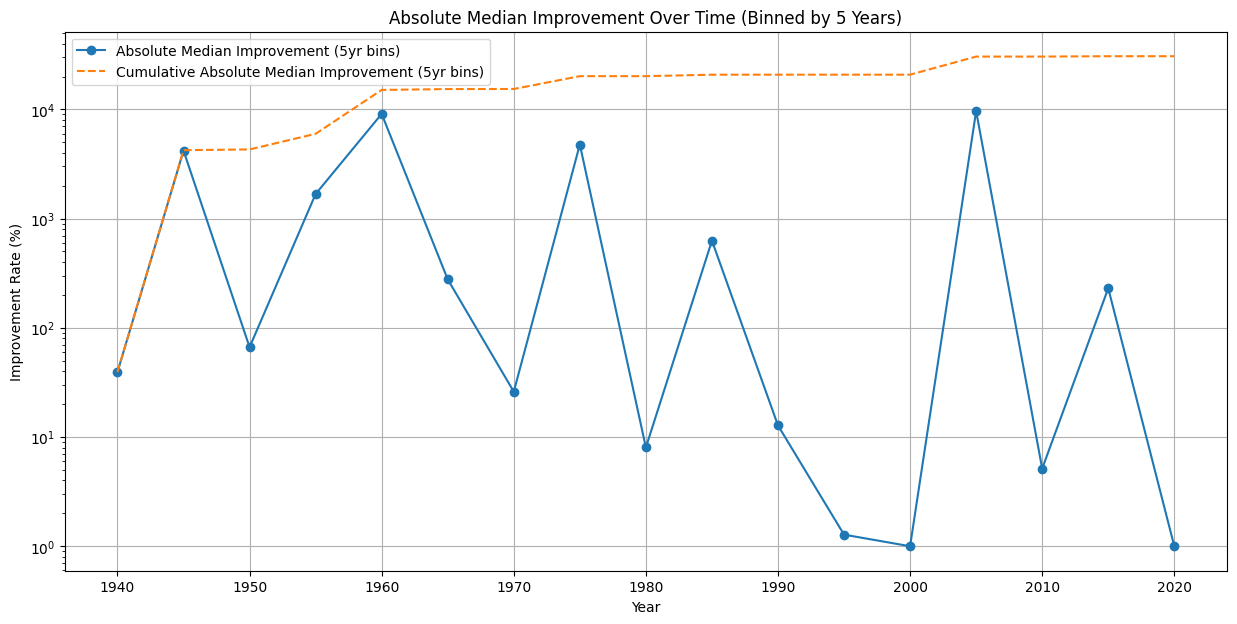

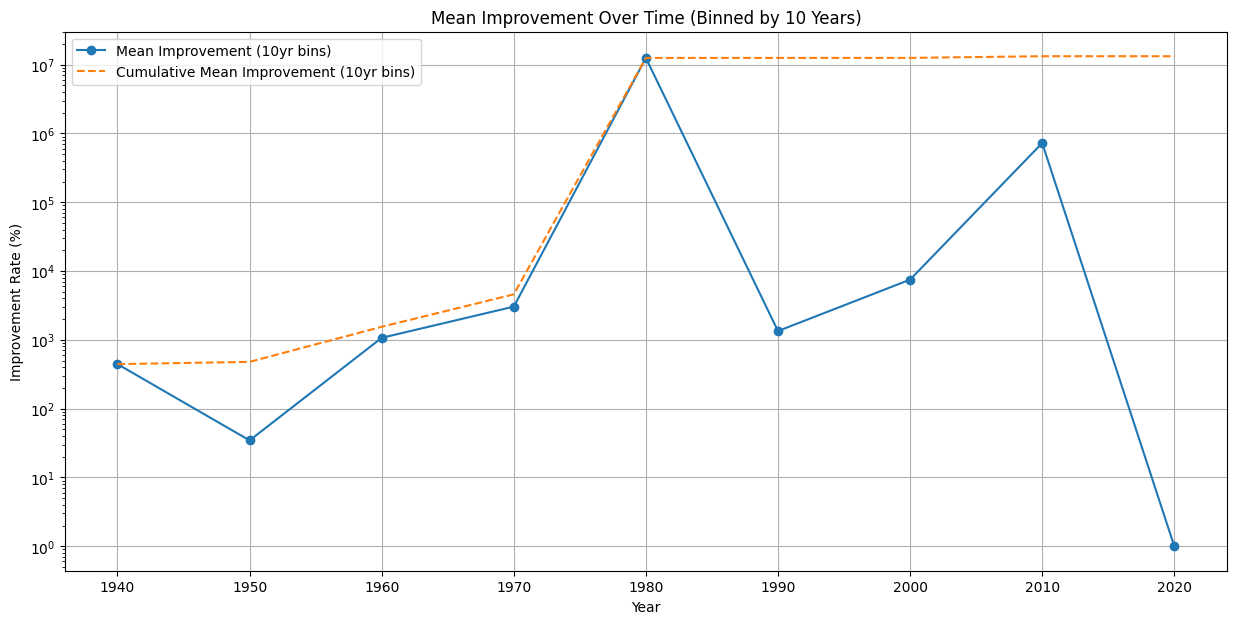

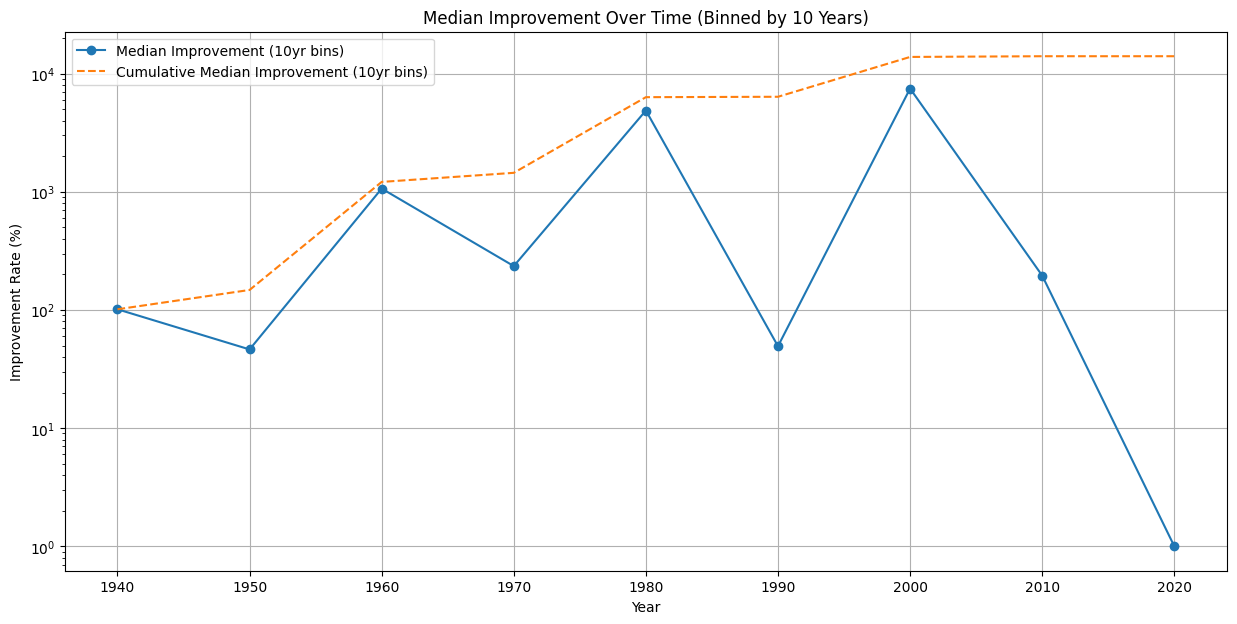

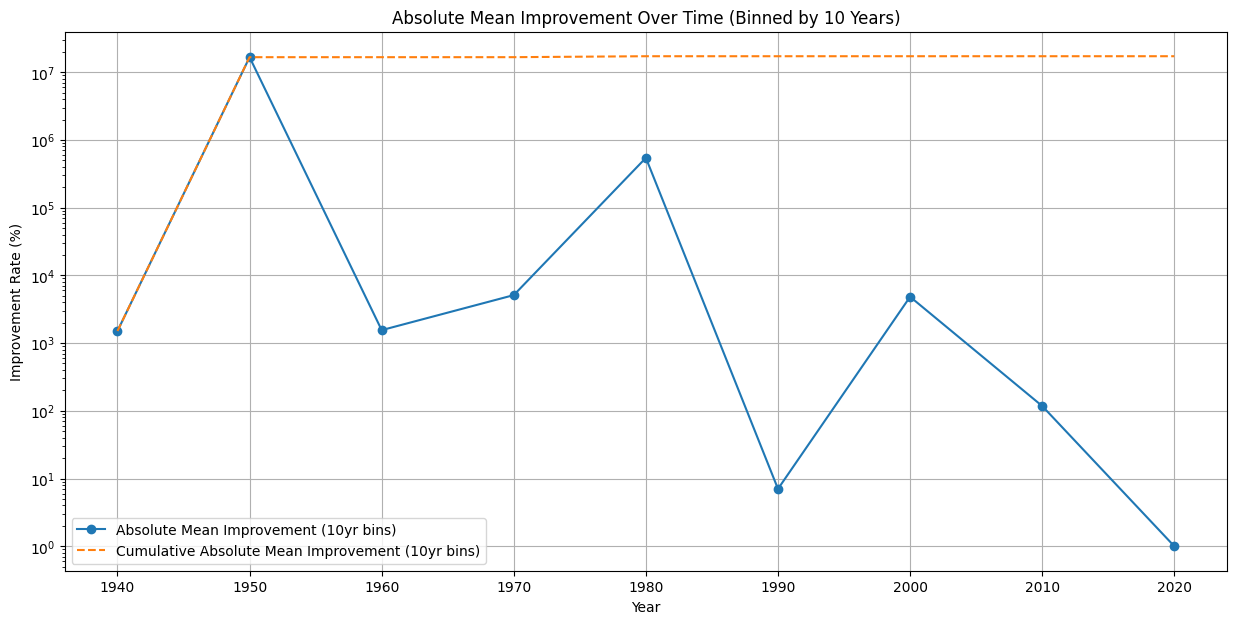

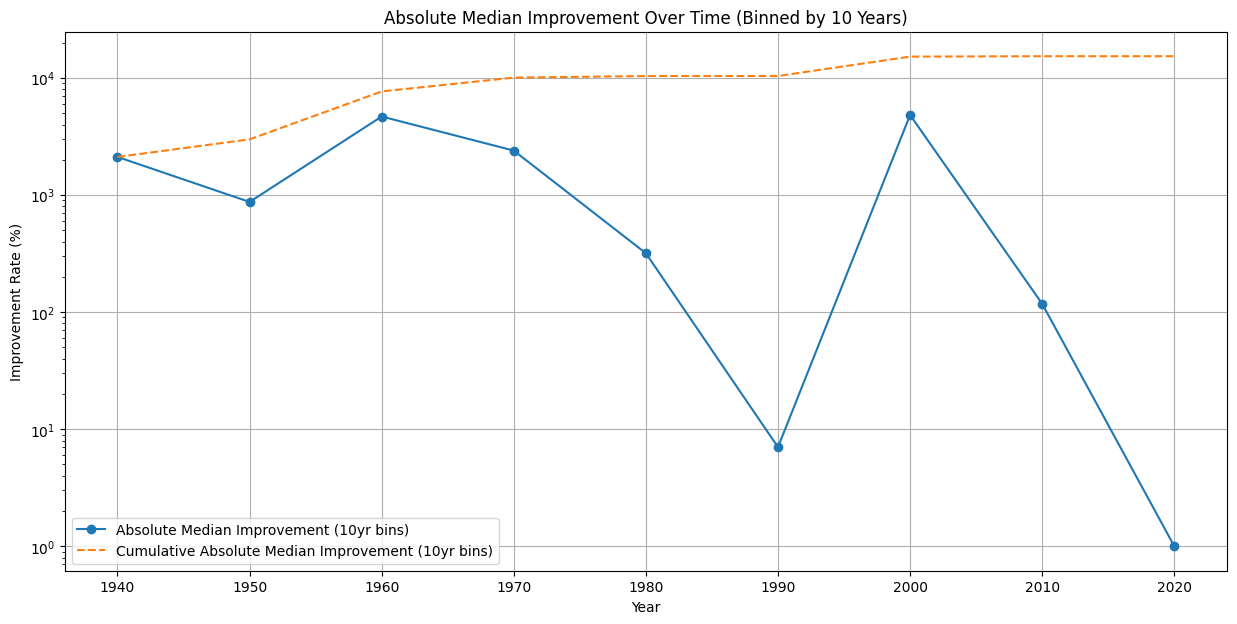

In [62]:
def bin_and_plot_improvement_rates(df, bin_sizes):
    """
    Bins the plots by increments of 5 years and 10 years for the Absolute and normal median and mean improvement rates over time.

    :param df: DataFrame containing the improvement rate data.
    :param bin_sizes: List of integers defining the bin sizes (e.g., [5, 10]).
    """

    plot_configs = [
        ('Average Mean Improvement', 'Mean Improvement'),
        ('Average Median Improvement', 'Median Improvement'),
        ('Abs Average Mean Improvement', 'Absolute Mean Improvement'),
        ('Abs Average Median Improvement', 'Absolute Median Improvement')
    ]

    for bin_size in bin_sizes:
        for column, label in plot_configs:
            # Create bins with the specified size
            bin_groups = df.groupby((df.index // bin_size) * bin_size)
            
            # Calculate mean or median for each bin and cumulative values
            improvement_rate = bin_groups[column].mean()
            cumulative_improvement_rate = improvement_rate.cumsum()

            # Plotting
            plt.figure(figsize=(15, 7))

            # Plot normal improvement rates
            plt.plot(improvement_rate.index, improvement_rate.values, label=f'{label} ({bin_size}yr bins)', marker='o')

            # Plot cumulative improvement rates
            plt.plot(cumulative_improvement_rate.index, cumulative_improvement_rate.values, label=f'Cumulative {label} ({bin_size}yr bins)', linestyle='--')

            # Labelling
            plt.xlabel('Year')
            plt.ylabel('Improvement Rate (%)')
            plt.title(f'{label} Over Time (Binned by {bin_size} Years)')
            plt.legend()
            plt.yscale("log")
            plt.grid(True)
            plt.show()

    

# Now let's call the function with bin sizes of 5 and 10 years.
bin_sizes = [5, 10]
bin_and_plot_improvement_rates(prepared_data, bin_sizes)

In [21]:
WINDOW_SIZE = 5  # This sets the window size for the moving average

def plot_average_improvement(df):
    plt.figure(figsize=(12, 6))
    
    # Plot the original data
    plt.plot(df.index-1940, df['Average Improvement'], label='Average Improvement', marker='o')
    
    # Plot the moving average
    plt.plot(df.index-1940, df['Average Improvement'].rolling(WINDOW_SIZE).mean(), label=f'Moving Average ({WINDOW_SIZE} yrs)', linestyle='--', color='red')
    plt.yscale("log")  # Use logarithmic scale for the y-axis
    plt.title("Average Improvement Over the Years (1940-2023)")
    plt.xlabel("Year")
    plt.ylabel("Improvement Rate (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_cumulative_improvement(df):
    plt.figure(figsize=(12, 6))
    plt.yscale("log")  # Use logarithmic scale for the y-axis
    # Plot the original data
    plt.plot(df.index-1940, df['Cumulative Improvement'], label='Cumulative Improvement', linestyle='-', marker='o')
    
    # Plot the moving average
    plt.plot(df.index-1940, df['Cumulative Improvement'].rolling(WINDOW_SIZE).mean(), label=f'Moving Average ({WINDOW_SIZE} yrs)', linestyle='--', color='red')
    plt.title("Cumulative Improvement Over the Years (1940-2023)")
    plt.xlabel("Year")
    plt.ylabel("Improvement Rate (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

prepared_data = prepare_data(all_years_df)
plot_average_improvement(prepared_data)
plot_cumulative_improvement(prepared_data)

KeyError: 'Average Improvement'

<Figure size 1200x600 with 0 Axes>

In [ ]:
from scipy.interpolate import UnivariateSpline

# Interpolate to make the plot continuous
y = interpolated_series.values
x = interpolated_series.index
spl = UnivariateSpline(x, y, s=1)

# Define a more dense range of x values for plotting the continuous curve
x_smooth = np.linspace(x.min(), x.max(), 1000)
y = spl(x_smooth)

# Plot
plt.figure(figsize=(15, 8))
plt.plot(x_smooth, y, label='Log Average (Continuous)', color='blue', linewidth=4)
plt.xlabel('Year')
plt.ylabel('Log of Improvement Rate (%)')
plt.title('Average Amortized Cost of Improvements Over Years (Continuous)')
plt.grid(True)
plt.style.use('ggplot')
plt.legend(loc='best')
plt.tight_layout()
plt.rcParams['font.size'] = 30
plt.rcParams['font.family'] = 'serif'
plt.show()

NameError: name 'interpolated_series' is not defined

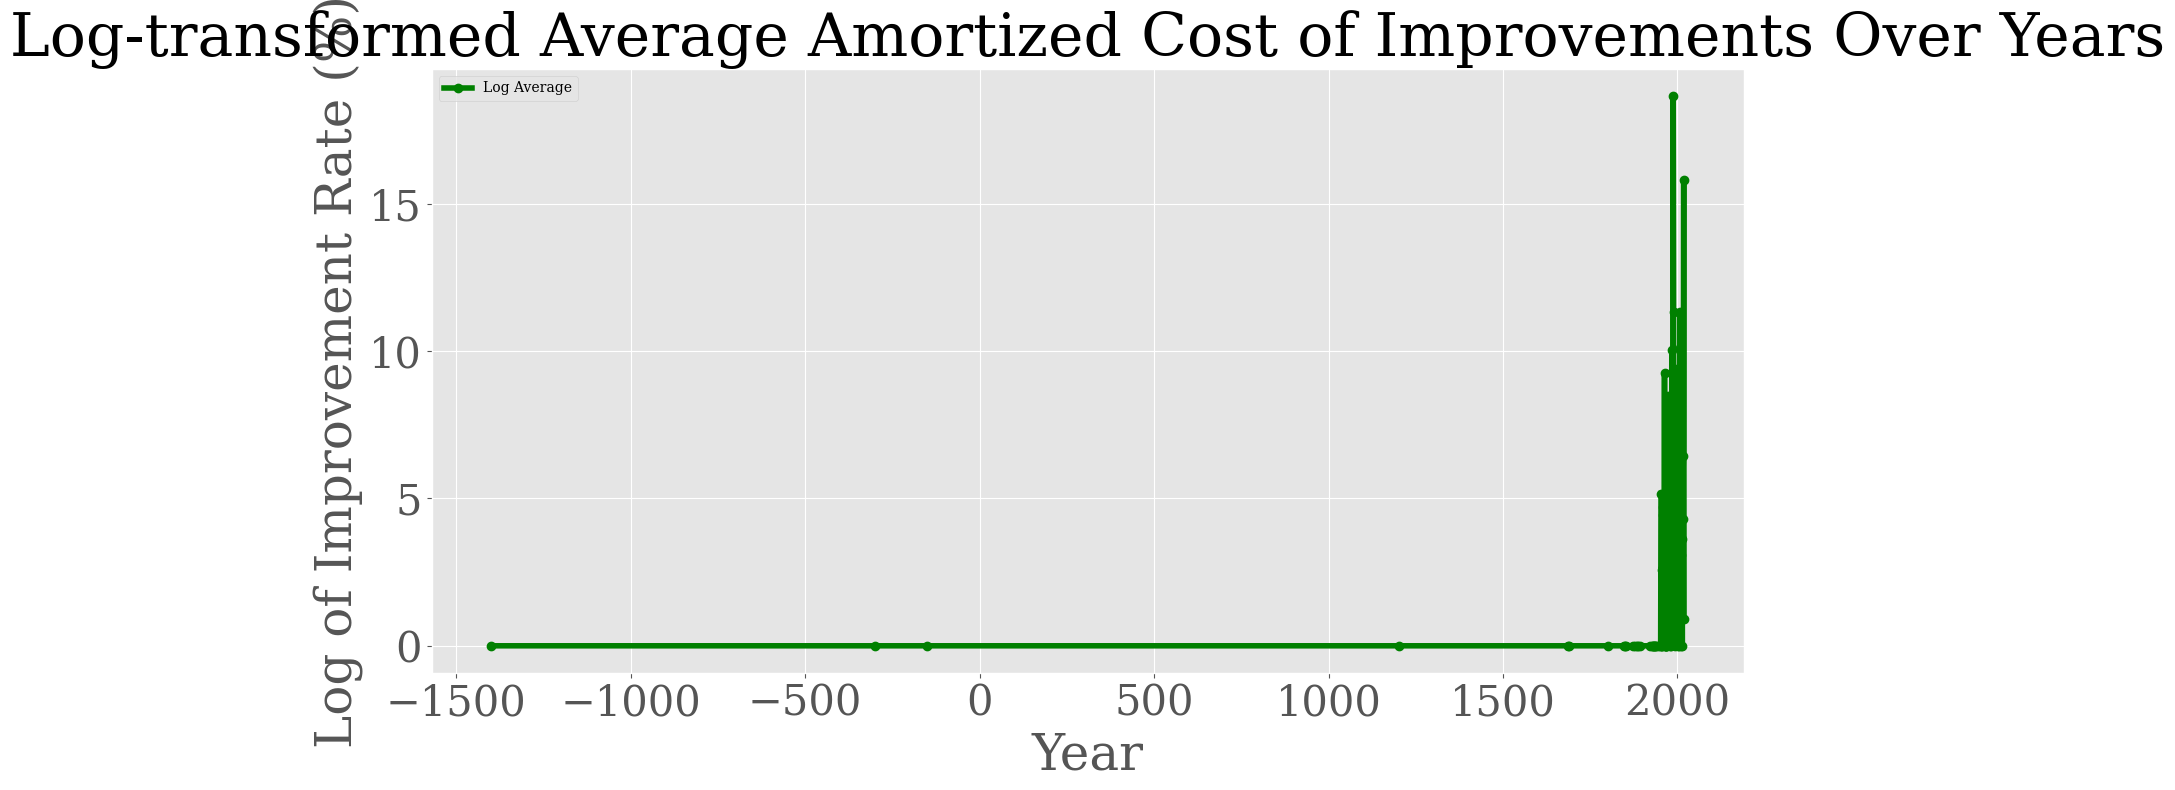

In [ ]:
# Plot the log 
log_average_series = np.log1p(average_series)

# Plot
plt.figure(figsize=(15, 8))
plt.plot(log_average_series.index, log_average_series, label='Log Average', color='green', linewidth=4, marker='o', markersize=6)
plt.xlabel('Year')
plt.ylabel('Log of Improvement Rate (%)')
plt.title('Log-transformed Average Amortized Cost of Improvements Over Years')
plt.grid(True)
plt.style.use('ggplot')
plt.legend(loc='best')
plt.tight_layout()
plt.rcParams['font.size'] = 30
plt.rcParams['font.family'] = 'serif'
plt.show()